In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import normaltest, mannwhitneyu, spearmanr
import pingouin as pg
import statsmodels.api as sm
from cliffs_delta import cliffs_delta

In [2]:
sb.set_context('paper', font_scale = 1.75)
sb.set_style("ticks", {'patch.edgecolor': 'black'})
sb.set_palette("tab10")

# Data preparation

In [3]:
categories = {
    'rating_1': 'Related',
    'rating_2': 'Unambiguous',
    'rating_3': 'Contextual',
    'rating_4': 'Insightful',
}

In [4]:
df_issues: pd.DataFrame = pd.read_csv('data/backend_issues.csv')
df_rating: pd.DataFrame = pd.read_csv('data/backend_rating.csv')

# Data provided by Herbold et al. (2020)
df_train_data: pd.DataFrame = pd.read_pickle('data/train_data_all.p')

### Selecting rater-id for rater-specific analysis

In [5]:
rater = 3
adjusted_rater_id = rater + 1 # starting at 2 because rater 1 is the admin

## Complete the issues table

In [6]:
# Add project key to each issue
for key in df_train_data.keys():
    df_train_data[key]['project'] = key

df_train_data = pd.concat(df_train_data[key] for key in df_train_data.keys())

# Merge with issues table from backend to get the result of the classification
df_issues = pd.merge(df_issues, df_train_data[['title', 'description', 'classification', 'project']], how='left', on=['title', 'description', 'project'])
df_issues.drop_duplicates(['id', 'classification'], inplace=True)
df_issues.reset_index(inplace=True)

# Extract prediction values which are stored as strings
def prediction_to_number(input: str):
    prediction: list = input.strip('"[]').split(', ')
    return 0 if prediction[0] > prediction[1] else 1

df_issues['classification'] = df_issues['classification'].astype(int)
df_issues['prediction'] = df_issues['prediction'].apply(lambda x: prediction_to_number(json.loads(x)))
df_issues['tp'] = df_issues[['prediction', 'classification']].apply(lambda x: (x['classification'] and x['prediction'] == 1), axis=1).astype(bool)
df_issues['tn'] = df_issues[['prediction', 'classification']].apply(lambda x: (not x['classification'] and x['prediction'] == 0), axis=1).astype(bool)
df_issues['fp'] = df_issues[['prediction', 'classification']].apply(lambda x: (not x['classification'] and x['prediction'] == 1), axis=1).astype(bool)
df_issues['fn'] = df_issues[['prediction', 'classification']].apply(lambda x: (x['classification'] and x['prediction'] == 0), axis=1).astype(bool)
df_issues = df_issues.join(pd.get_dummies(df_issues['project'], dtype=int))

## Complete the ratings table

In [7]:
# Reconstruct rating order
user_cnt = {}

def get_n(user: str, algorithm: str):
    global user_cnt
    if not user in user_cnt:
        user_cnt[user] = 0
    if algorithm == 'shap':
        user_cnt[user] += 1

    return user_cnt[user]


df_rating['n'] = df_rating.apply(lambda x: get_n(x['user_id'], x['algorithm']), axis=1)

# Add issue information
df_rating = pd.merge(df_rating, df_issues, how='left', left_on=['issue_id'], right_on=['id'], suffixes=('', '_merged'))

## Create table for $qs$

In [8]:
def get_mean_data(df_rating_subset):

    mean_data = []

    for keys, group in df_rating_subset[df_rating_subset['user_id'] == adjusted_rater_id].groupby(['issue_id', 'algorithm']):
        qs = (group['rating_1'] + group['rating_2'] + group['rating_3'] + group['rating_4']).mean()
        mean_data.append({
            'issue_id': keys[0],
            'algorithm': keys[1],
            'qs': qs,
            'rating_1': group['rating_1'].mean(),
            'rating_2': group['rating_2'].mean(),
            'rating_3': group['rating_3'].mean(),
            'rating_4': group['rating_4'].mean(),
            f'n{rater}': group[group['user_id'] == adjusted_rater_id]['n'].iloc[0]
        })

    result = pd.DataFrame(mean_data)
    return pd.merge(result, df_issues, how='left', left_on=['issue_id'], right_on=['id'], suffixes=('', '_merged'))

df_mean = get_mean_data(df_rating)

# Analysis

## Distribution of $qs$

Distribution of $qs$ (a) per algorithm; (b) for predictions as bugs ($tp$, $fp$) and non-bugs ($tn$, $fn$); (c) correct predictions ($tp$, $tn$) and incorrect predictions ($fp$, $fn$); and (d) correct predictions of bugs ($tp$) and correct predictions of non-bugs ($tn$).

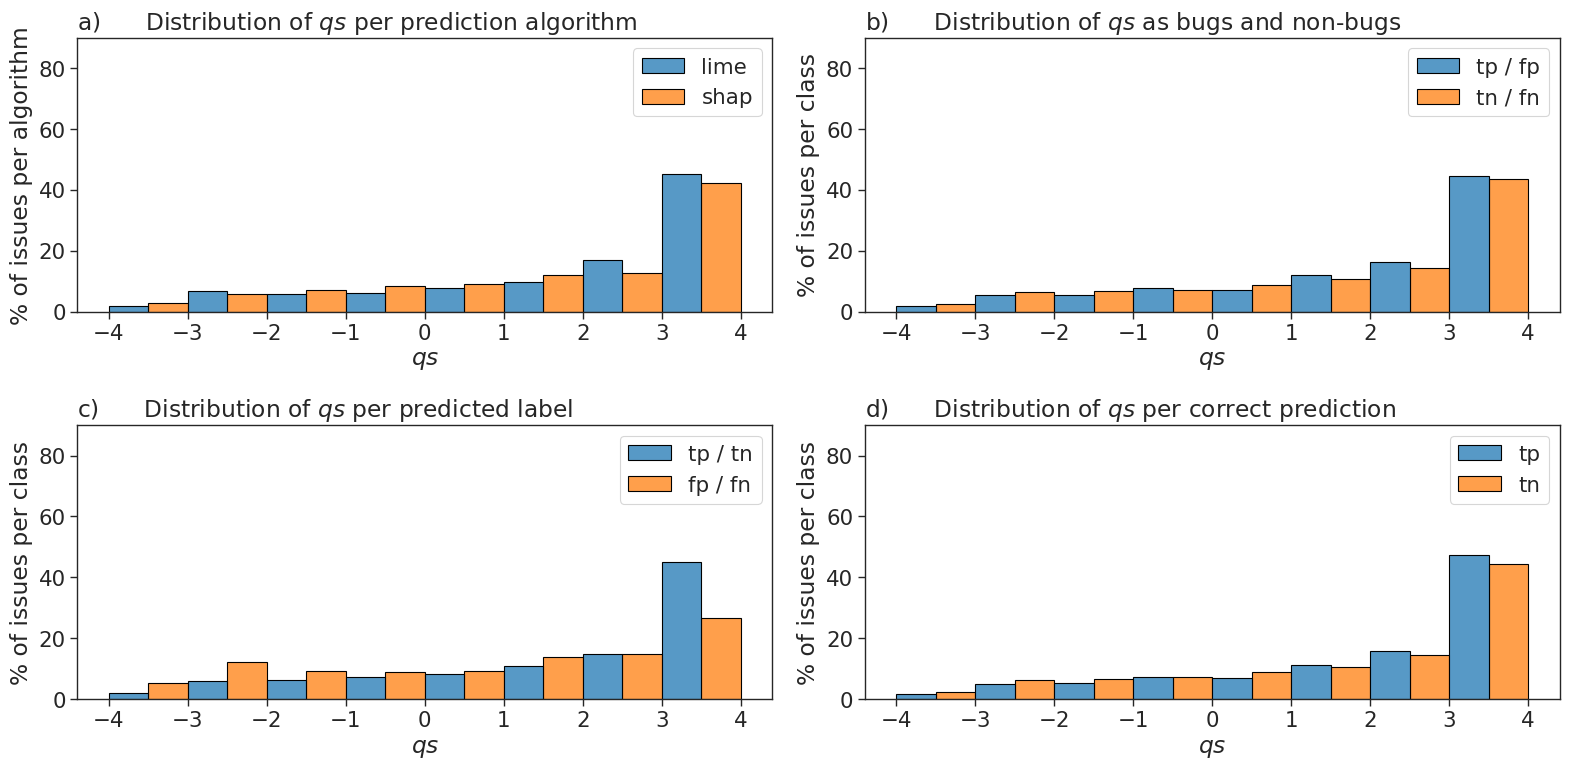

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,8))

ylim = 90

a = pd.DataFrame({
    'lime': df_mean[df_mean['algorithm'] == 'lime']['qs'], 
    'shap': df_mean[df_mean['algorithm'] == 'shap']['qs'], 
})
sb.histplot(a, bins=8, ax=ax1, stat="percent", common_norm=False, multiple='dodge')

ax1.set_title('a)\tDistribution of $qs$ per prediction algorithm', loc='left')
ax1.set_ylabel(r'% of issues per algorithm')
ax1.set_xlabel('$qs$')
ax1.set_ylim([0, ylim])

a = pd.DataFrame({
    'tp / fp': df_mean[(df_mean['tp'] == 1) | (df_mean['fp'] == 1)]['qs'], 
    'tn / fn': df_mean[(df_mean['tn'] == 1) | (df_mean['fn'] == 1)]['qs'], 
})
sb.histplot(a, bins=8, ax=ax2, stat="percent", common_norm=False, multiple='dodge')

ax2.set_title('b)\tDistribution of $qs$ as bugs and non-bugs', loc='left')
ax2.set_ylabel(r'% of issues per class')
ax2.set_xlabel('$qs$')
ax2.set_ylim([0, ylim])


b = pd.DataFrame({
    'tp / tn': df_mean[(df_mean['tp'] == 1) | (df_mean['tn'] == 1)]['qs'], 
    'fp / fn': df_mean[(df_mean['fp'] == 1) | (df_mean['fn'] == 1)]['qs'], 
})

sb.histplot(b, bins=8, ax=ax3, stat="percent", common_norm=False, multiple='dodge')

ax3.set_title('c)\tDistribution of $qs$ per predicted label', loc='left')
ax3.set_ylabel(r'% of issues per class')
ax3.set_xlabel('$qs$')
ax3.set_ylim([0, ylim])

a = pd.DataFrame({
    'tp': df_mean[(df_mean['tp'] == 1)]['qs'], 
    'tn': df_mean[(df_mean['tn'] == 1)]['qs'], 
})
sb.histplot(a, bins=8, ax=ax4, stat="percent", common_norm=False, multiple='dodge')

ax4.set_title('d)\tDistribution of $qs$ per correct prediction', loc='left')
ax4.set_ylabel(r'% of issues per class')
ax4.set_xlabel('$qs$')
ax4.set_ylim([0, ylim])

fig.tight_layout()

## Distribution of ratings per category, per algorithm.

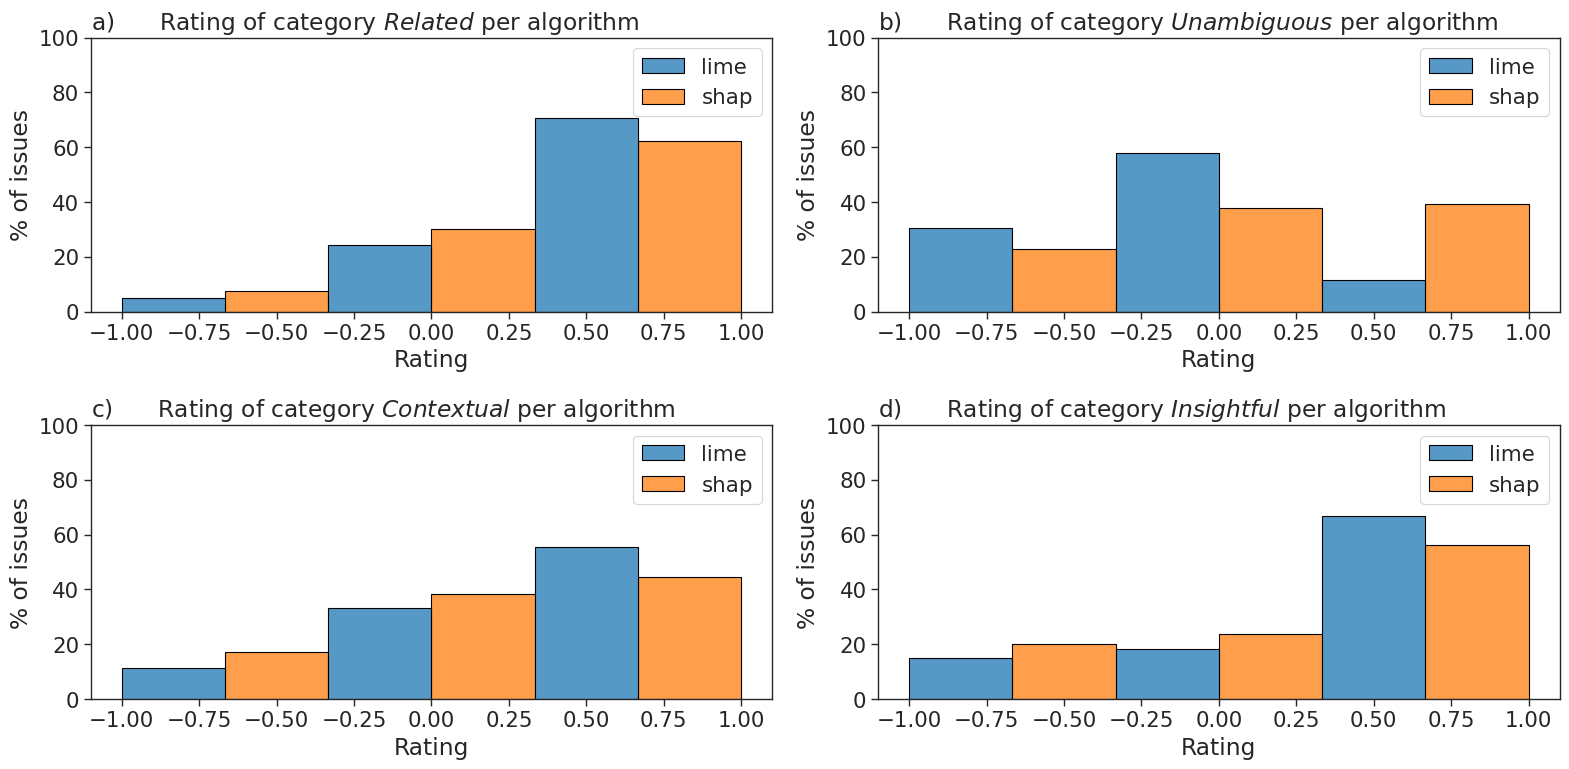

In [10]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,8))

axs = [None, ax1, ax2, ax3, ax4]
for i in range(1, 5):

    category = categories[f'rating_{i}']
    ax = axs[i]
    ax.set_title(f'{["a", "b", "c", "d"][i-1]})\tRating of category ${category}$ per algorithm', loc='left')

    df_tmp = pd.DataFrame({
        'lime': df_mean[df_mean['algorithm'] == 'lime'][f'rating_{i}'],
        'shap': df_mean[df_mean['algorithm'] == 'shap'][f'rating_{i}']
    })
    sb.histplot(df_tmp, bins=3, ax=ax, stat="percent", common_norm=False, multiple='dodge', fill=True)
    ax.set_xlabel(f'Rating')
    ax.set_ylabel(f'% of issues')
    ax.set_ylim([0, 100])

fig.tight_layout()

## Correlation of categories

Correlation between the ratings per category, calculated with Spearman's $\rho$.

[Text(0, 0.5, 'Related'),
 Text(0, 1.5, 'Unambiguous'),
 Text(0, 2.5, 'Contextual'),
 Text(0, 3.5, 'Insightful')]

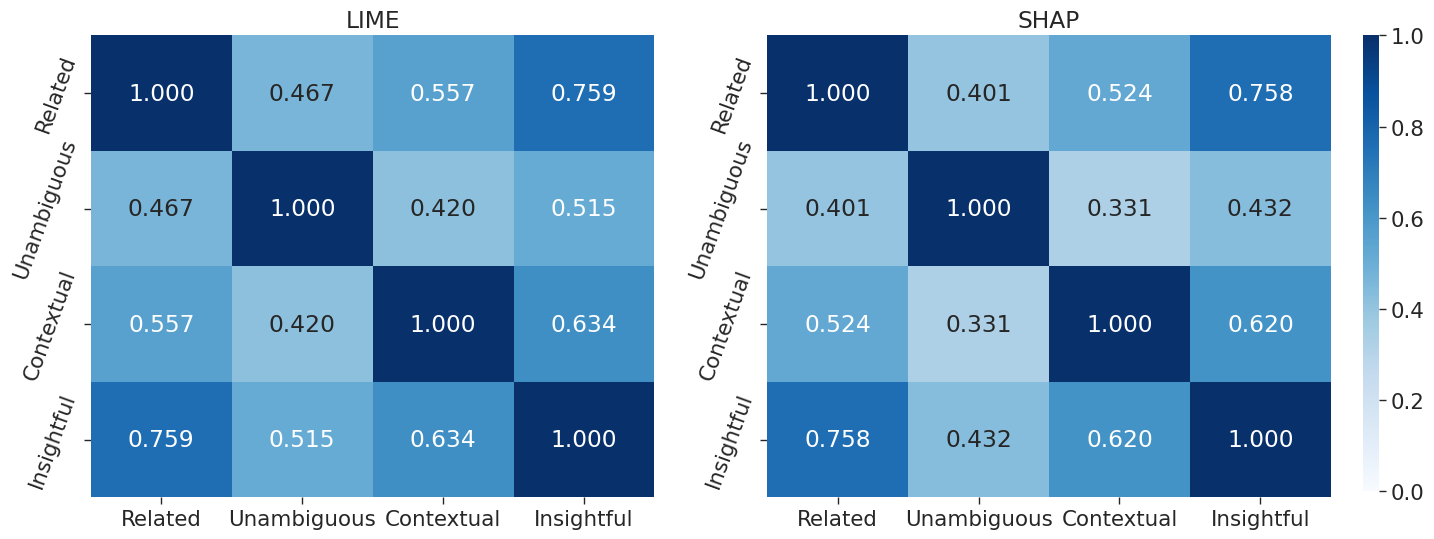

In [11]:
fig, ((ax2, ax1)) = plt.subplots(1, 2, figsize=(16,6))
cmap = sb.color_palette("Blues", as_cmap=True)

labels = [category for category in list(categories.values()) ]
cbar_ax = fig.add_axes([.92, .12, .01, .76])

df_rating_lime = df_mean[df_mean['algorithm'] == 'lime'][['rating_1', 'rating_2', 'rating_3', 'rating_4']]

ax2.set_title('LIME')
ax2 = sb.heatmap(df_rating_lime.corr(method='spearman'), xticklabels=labels, yticklabels=labels, annot = True, fmt='.3f', vmin=0, vmax=1, cmap=cmap, ax=ax2, cbar_ax=cbar_ax)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=70)

df_rating_shap = df_mean[df_mean['algorithm'] == 'shap'][['rating_1', 'rating_2', 'rating_3', 'rating_4']]

ax1.set_title('SHAP')
ax1 = sb.heatmap(df_rating_shap.corr(method='spearman'), xticklabels=labels, yticklabels=labels, annot = True, fmt='.3f', vmin=0, vmax=1, cmap=cmap, ax=ax1, cbar_ax=cbar_ax)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=70)

## Linear model

In [12]:
x = df_mean[['tp', 'tn', 'fp', 'fn', f'n{rater}'] + sorted(list(df_mean['project'].unique()))].astype('double')

x = sm.add_constant(x)

y = df_mean['qs']

model = sm.OLS(y, x).fit(use_t=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     qs   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     17.42
Date:                Thu, 28 Sep 2023   Prob (F-statistic):          3.09e-116
Time:                        10:49:30   Log-Likelihood:                -13431.
No. Observations:                6180   AIC:                         2.695e+04
Df Residuals:                    6138   BIC:                         2.723e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1370      0.064     -2.150      0.032      -0.262      -0.012
tp                        0.7906      0.070     11.226      0.000       0.653       0.929
tn                        0.5142      0.057      9.077      0.000       0.403       0.625
fp                        0.2422      0.113      2.146      0.032       0.021       0.463
fn                       -1.6839      0.160    -10.511      0.000      -1.998      -1.370
n3                        0.0007   3.07e-05     21.963      0.000       0.001       0.001
ant-ivy                  -0.5143      0.142     -3.626      0.000      -0.792      -0.236
archiva                  -0.2126      0.144     -1.478      0.139      -0.494       0.069
calcite                   0.0580      0.128      0.452      0.651      -0.194       0.310
cayenne                   0.0139      0.118      0.118      0.906      -0.218       0.245
commons-bcel             -0.0927      0.409     -0.226      0.821      -0.895       0.710
commons-beanutils        -0.6283      0.285     -2.202      0.028      -1.187      -0.069
commons-codec             0.5525      0.348      1.586      0.113      -0.130       1.235
commons-collections       0.2203      0.227      0.969      0.333      -0.225       0.666
commons-compress         -0.0967      0.245     -0.395      0.693      -0.576       0.383
commons-configuration     0.1792      0.216      0.830      0.406      -0.244       0.602
commons-dbcp             -0.4442      0.276     -1.609      0.108      -0.985       0.097
commons-digester          0.4284      0.467      0.918      0.359      -0.486       1.343
commons-io               -0.3236      0.227     -1.425      0.154      -0.769       0.122
commons-jcs               0.3082      0.410      0.752      0.452      -0.495       1.111
commons-jexl              0.3305      0.302      1.093      0.274      -0.262       0.923
commons-lang              0.2290      0.146      1.565      0.118      -0.058       0.516
commons-math             -0.1170      0.141     -0.830      0.406      -0.393       0.159
commons-net               0.1208      0.242      0.500      0.617      -0.353       0.595
commons-scxml            -0.0023      0.302     -0.007      0.994      -0.595       0.590
commons-validator        -0.3052      0.286     -1.069      0.285      -0.865       0.255
commons-vfs              -0.0630      0.232     -0.271      0.787      -0.519       0.393
deltaspike                0.1599      0.159      1.009      0.313      -0.151       0.471
eagle                     0.3342      0.164      2.038      0.042       0.013       0.656
giraph                    0.0179      0.155      0.115      0.908      -0.286       0.321
gora                     -0.0084      0.216     -0.039      0.969      -0.431       0.414
jspwiki                

## Subset statistics

In [13]:
df_tp = df_mean[df_mean['tp'] == 1]
df_tn = df_mean[df_mean['tn'] == 1]
df_fp = df_mean[df_mean['fp'] == 1]
df_fn = df_mean[df_mean['fn'] == 1]

In [14]:
result = []

print(normaltest(df_tp['qs']), normaltest(df_tn['qs']))

mw_test = mannwhitneyu(df_tp['qs'], df_tn['qs'])
cd_test = cliffs_delta(df_tp['qs'], df_tn['qs'])

result = [
    {
        'Variables': '$tp$, $tn$',
        'median': f'{df_tp["qs"].median()}, {df_tn["qs"].median()}',
        'p-value': mw_test[1],
        'Cliff\'s $\delta$': cd_test[0],
        'Effect size': cd_test[1]
    },  
]

NormaltestResult(statistic=118.09595599536229, pvalue=2.2687622538536353e-26) NormaltestResult(statistic=464.23538871832244, pvalue=1.5579954596656184e-101)


In [15]:
df_lime = df_mean[df_mean['algorithm'] == 'lime']
df_shap = df_mean[df_mean['algorithm'] == 'shap']

In [16]:
print(normaltest(df_lime['qs']), normaltest(df_shap['qs']))

mw_test = mannwhitneyu(df_shap['qs'], df_lime['qs'])

cd_test = cliffs_delta(list(df_shap['qs']), list(df_lime['qs']))

result.append({
    'Variables': 'LIME, SHAP',
    'median': f'{df_lime["qs"].median()}, {df_shap["qs"].median()}',
    'p-value': mw_test[1],
    'Cliff\'s $\delta$': cd_test[0],
    'Effect size': cd_test[1]
})

NormaltestResult(statistic=338.37838870441334, pvalue=3.3271049096705525e-74) NormaltestResult(statistic=363.46356745268395, pvalue=1.1881988869519405e-79)


In [17]:
pd.DataFrame(result)

,Variables,median,p-value,Cliff's $\delta$,Effect size
0,"$tp$, $tn$","2.0, 2.0",0.000454,0.065683,negligible
1,"LIME, SHAP","2.0, 2.0",0.664997,0.006258,negligible
